In [19]:
import math

def calculate_distance(rgb1, rgb2):
    r1, g1, b1 = rgb1
    r2, g2, b2 = rgb2
    return math.sqrt((r2 - r1) ** 2 + (g2 - g1) ** 2 + (b2 - b1) ** 2)

dct={}
def find_closest_rgb(rgb, rgb_values):
    if str(rgb[:2]) in dct:
        return dct[str(rgb[:2])]
    closest_rgb = None
    closest_distance = float('inf')
    for rgb_value in rgb_values:
        if rgb_value[:3] == [-1, -1, -1]:
            closest_rgb = [-1, -1, -1]
            return closest_rgb
        distance = calculate_distance(rgb, rgb_value[:3])
        if distance < closest_distance:
            closest_distance = distance
            closest_rgb = rgb_value
    dct[str(rgb[:2])]=closest_rgb
    return closest_rgb

In [6]:
from PIL import Image
import csv
# Read the RGB and temperature values from the first CSV file
with open('rgb_temperature_values.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row if it exists
    rgb_temperature_values = [list(map(int, row[:4])) for row in reader]


In [7]:


# Load the temperature color map image
image1 = Image.open("../../Data/Images/original/2000_LST.bmp")
image2 = Image.open("../../Data/Images/original/2010_LST.bmp")
image3= Image.open("../../Data/Images/original/2020_LST.bmp")

# Resize image2 and image3 to match the resolution of image1
image2 = image2.resize(image1.size)
image3 = image3.resize(image1.size)

images = [image1, image2, image3]

csv_path1= "2000_og.csv"
csv_path2= "2010_og.csv"
csv_path3= "2020_og.csv"
csv_paths = [csv_path1, csv_path2, csv_path3]

In [8]:
# for image, csv_path in zip(images,csv_paths):
#     # Create a CSV file to store the temperature data
#     csv_file = open(csv_path, "w", newline="")
#     csv_writer = csv.writer(csv_file)
#     csv_writer.writerow(["X", "Y", "r", "g", "b", "Temperature"])
    
#     # Iterate over each pixel in the image and extract temperature data
#     pixels = image.load()
#     width, height = image.size

#     for x in range(width):
#         for y in range(height):
#             r, g, b = pixels[x, y]
#             closest_rgb = find_closest_rgb([r,g,b], rgb_temperature_values)
#             csv_writer.writerow([x, y] + closest_rgb)
#     # Close the CSV file
#     csv_file.close()


In [9]:
csv_file = open("2000_og.csv", "w", newline="")
csv_writer = csv.writer(csv_file)
csv_writer.writerow(["X", "Y", "r", "g", "b", "Temperature"])

# Iterate over each pixel in the image and extract temperature data
pixels = image1.load()
width, height = image1.size

for x in range(width):
    for y in range(height):
        r, g, b = pixels[x, y]
        closest_rgb = find_closest_rgb([r,g,b], rgb_temperature_values)
        csv_writer.writerow([x, y] + closest_rgb)
# Close the CSV file
csv_file.close()

In [20]:
csv_file = open("2010_og.csv", "w", newline="")
csv_writer = csv.writer(csv_file)
csv_writer.writerow(["X", "Y", "r", "g", "b", "Temperature"])

# Iterate over each pixel in the image and extract temperature data
pixels = image2.load()

for x in range(width):
    for y in range(height):
        r, g, b = pixels[x, y]
        closest_rgb = find_closest_rgb([r,g,b], rgb_temperature_values)
        csv_writer.writerow([x, y] + closest_rgb)
# Close the CSV file
csv_file.close()

In [21]:
csv_file = open("2020_og.csv", "w", newline="")
csv_writer = csv.writer(csv_file)
csv_writer.writerow(["X", "Y", "r", "g", "b", "Temperature"])

# Iterate over each pixel in the image and extract temperature data
pixels = image3.load()

for x in range(width):
    for y in range(height):
        r, g, b = pixels[x, y]
        closest_rgb = find_closest_rgb([r,g,b], rgb_temperature_values)
        csv_writer.writerow([x, y] + closest_rgb)
# Close the CSV file
csv_file.close()

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

In [23]:
# Read the CSV files
df_2000 = pd.read_csv('2000_og.csv')
df_2010 = pd.read_csv('2010_og.csv')
df_2020 = pd.read_csv('2020_og.csv')

# Extract the third column as input and output
data_2000 = df_2000.iloc[:, 5].values
data_2010 = df_2010.iloc[:, 5].values
data_2020 = df_2010.iloc[:, 5].values

In [24]:
# Preprocess the data
# (Perform any necessary preprocessing steps such as scaling or normalization here)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_2000, data_2010, test_size=0.2)

# Reshape the data for LSTM input (assuming 1 feature per timestep)
X_train = np.reshape(X_train, (X_train.shape[0], 1, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 1))

In [25]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(1, 1)))  # Adjust the number of units (128) as needed
model.add(Dense(1))  # Output layer with 1 unit

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=2, batch_size=32)  # Adjust batch_size and epochs as needed

# Evaluate the model
loss = model.evaluate(X_test, y_test)

# Make predictions
predictions = model.predict(X_test)

Epoch 1/2
32563/32563 [==============================] - 105s 3ms/step - loss: 203.3598
Epoch 2/2
8141/8141 [==============================] - 14s 2ms/step


RMSE: 14.049868051568819


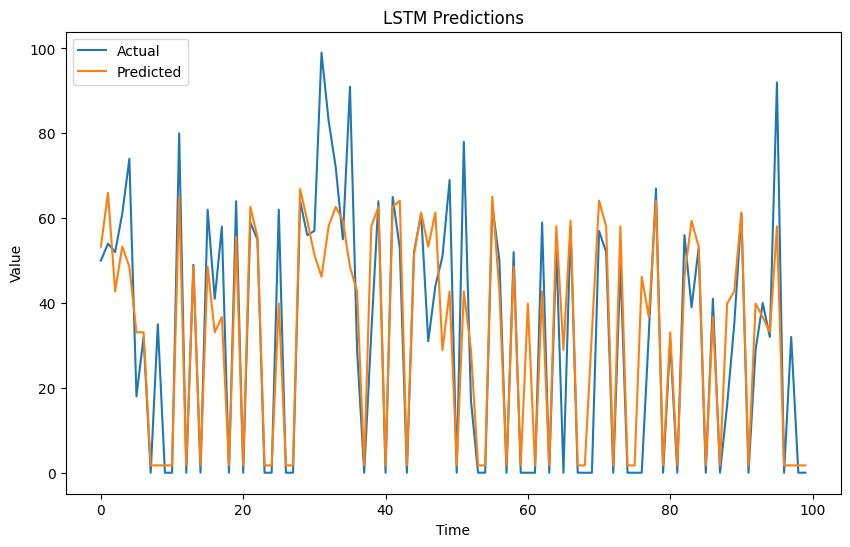

In [26]:
import matplotlib.pyplot as plt

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE:', rmse)

# Visualize the predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test[0:100], label='Actual')
plt.plot(predictions[0:100], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('LSTM Predictions')
plt.legend()
plt.show()

In [27]:
predict_input = np.reshape(data_2010, (data_2010.shape[0], 1, 1))
predictions_2020 = model.predict(predict_input)


40703/40703 [==============================] - 58s 1ms/step


In [ ]:
predict_input = np.reshape(data_2020, (data_2020.shape[0], 1, 1))
predictions_2030 = model.predict(predict_input)

In [55]:
predictions_2020 = predictions_2020.ravel()
predictions_2030 = predictions_2030.ravel()

In [56]:
predictions_2020

array([1.7227616, 1.7227616, 1.7227616, ..., 1.7227616, 1.7227616,
       1.7227616], dtype=float32)

In [57]:
predict_df_2020=df_2000.copy()
predict_df_2030=df_2000.copy()

In [58]:
# change 2nd row values of 2nd and 3rd coloumn of the dataframe


In [59]:
predict_df_2020.head()

,X,Y,r,g,b,Temperature
0,0,0,0,0,0,0
1,0,1,0,0,0,0
2,0,2,0,0,0,0
3,0,3,0,0,0,0
4,0,4,0,0,0,0


In [60]:
def calculate_dist_temp(t1, t2):
    return abs(t1-t2)

def find_closest_temp(temp):
    closest_rgb = None
    closest_distance = float('inf')
    for rgb_value in rgb_temperature_values:
        distance = calculate_dist_temp(temp, rgb_value[3])
        if distance < closest_distance:
            closest_distance = distance
            closest_rgb = rgb_value
    return closest_rgb

In [78]:
temp_dict = {}

# Iterate over the predictions and update the DataFrame
for index, temp in enumerate(predictions_2020):
    if temp in temp_dict:
        closest_rgb = temp_dict[temp]
    else:
        closest_rgb = None
        closest_distance = float('inf')
        for rgb_value in rgb_temperature_values:
            # distance = calculate_dist_temp(temp, rgb_value[3])
            distance = abs(rgb_value[3]-temp)
            if distance < closest_distance:
                closest_distance = distance
                closest_rgb = rgb_value
        temp_dict[temp] = closest_rgb

    predict_df_2020.loc[index, ['r', 'g', 'b', 'Temperature']] = closest_rgb[:4]


In [ ]:
for index, temp in enumerate(predictions_2030):
    if temp in temp_dict:
        closest_rgb = temp_dict[temp]
    else:
        closest_rgb = None
        closest_distance = float('inf')
        for rgb_value in rgb_temperature_values:
            # distance = calculate_dist_temp(temp, rgb_value[3])
            distance = abs(rgb_value[3]-temp)
            if distance < closest_distance:
                closest_distance = distance
                closest_rgb = rgb_value
        temp_dict[temp] = closest_rgb

    predict_df_2030.loc[index, ['r', 'g', 'b', 'Temperature']] = closest_rgb[:4]

In [62]:
# Iterate over rows in the DataFrame and modify values
# for index, row in predict_df.iterrows():
#     closest_rgb = find_closest_temp(predictions_2020[index])
#     predict_df.loc[index, ['r', 'g', 'b', 'Temperature']] = closest_rgb[:4]


In [75]:
# df to csv
predict_df_2020.to_csv('predicted_2020.csv', index=False)
predict_df_2030.to_csv('predicted_2030.csv', index=False)


In [76]:
# Read the CSV file
data = pd.read_csv('predicted_2020.csv')

# Get the maximum row and column values
max_row = data['Y'].max()
max_column = data['X'].max()

# Create a blank image with the size based on the maximum row and column values
imag1 = np.zeros((max_row + 1, max_column + 1, 3), dtype=np.uint8)

# Iterate over the rows of the CSV data
for index, row in data.iterrows():
    r, c, red, green, blue, t = row['Y'], row['X'], row['r'], row['g'], row['b'], row['Temperature']
    if t==2:
        red, green, blue = 0, 0, 0
    imag1[r, c] = (blue, green, red)  # Set the pixel value in the image



In [ ]:
# Read the CSV file
data = pd.read_csv('predicted_2030.csv')

# Get the maximum row and column values
max_row = data['Y'].max()
max_column = data['X'].max()

# Create a blank image with the size based on the maximum row and column values
imag2 = np.zeros((max_row + 1, max_column + 1, 3), dtype=np.uint8)

# Iterate over the rows of the CSV data
for index, row in data.iterrows():
    r, c, red, green, blue, t = row['Y'], row['X'], row['r'], row['g'], row['b'], row['Temperature']
    if t==2:
        red, green, blue = 0, 0, 0
    imag2[r, c] = (blue, green, red)  # Set the pixel value in the image



In [77]:
import cv2

# Display the image
# cv2.imshow('Image', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Save the reconstructed image
output_image_path = "output_image.bmp"
cv2.imwrite(output_image_path, imag1)

print("Image saved successfully.")

Image saved successfully.


In [ ]:
output_image_path = "output_image.bmp"
cv2.imwrite(output_image_path, imag2)

print("Image saved successfully.")